<a href="https://colab.research.google.com/github/MayerT1/Prep_GEDI/blob/main/GEDI_L2B_Target_fetch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthaccess harmony-py hvplot folium geopandas geoviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import os

# Define the base project folder and subdirectories
base_dir = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project'
subdirs = [
    'target_data',
    'GEDI_target',
    'data',
    'models',
    'scripts',
    'notebooks',
    'config',
    'results'
]

# Create each subdirectory
for subdir in subdirs:
    path = os.path.join(base_dir, subdir)
    os.makedirs(path, exist_ok=True)
    print(f"Created: {path}")


In [ ]:
!pwd

In [ ]:
%cd /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project

Make a new folder to work in and change directory to that location

In [ ]:
# !mkdir Module_2_GEDI_L2b

# !mkdir Module_2_GEDI_L2b/SPB_AOI
# !mkdir Module_2_GEDI_L2b/Prescribed_Burn_AOI
# !mkdir Module_2_GEDI_L2b/Sewanee_Domain
# !mkdir Module_2_GEDI_L2b/PaintRock_AOI

Change directory to that new folder

In [ ]:
# %cd /content/Module_2_GEDI_L2b

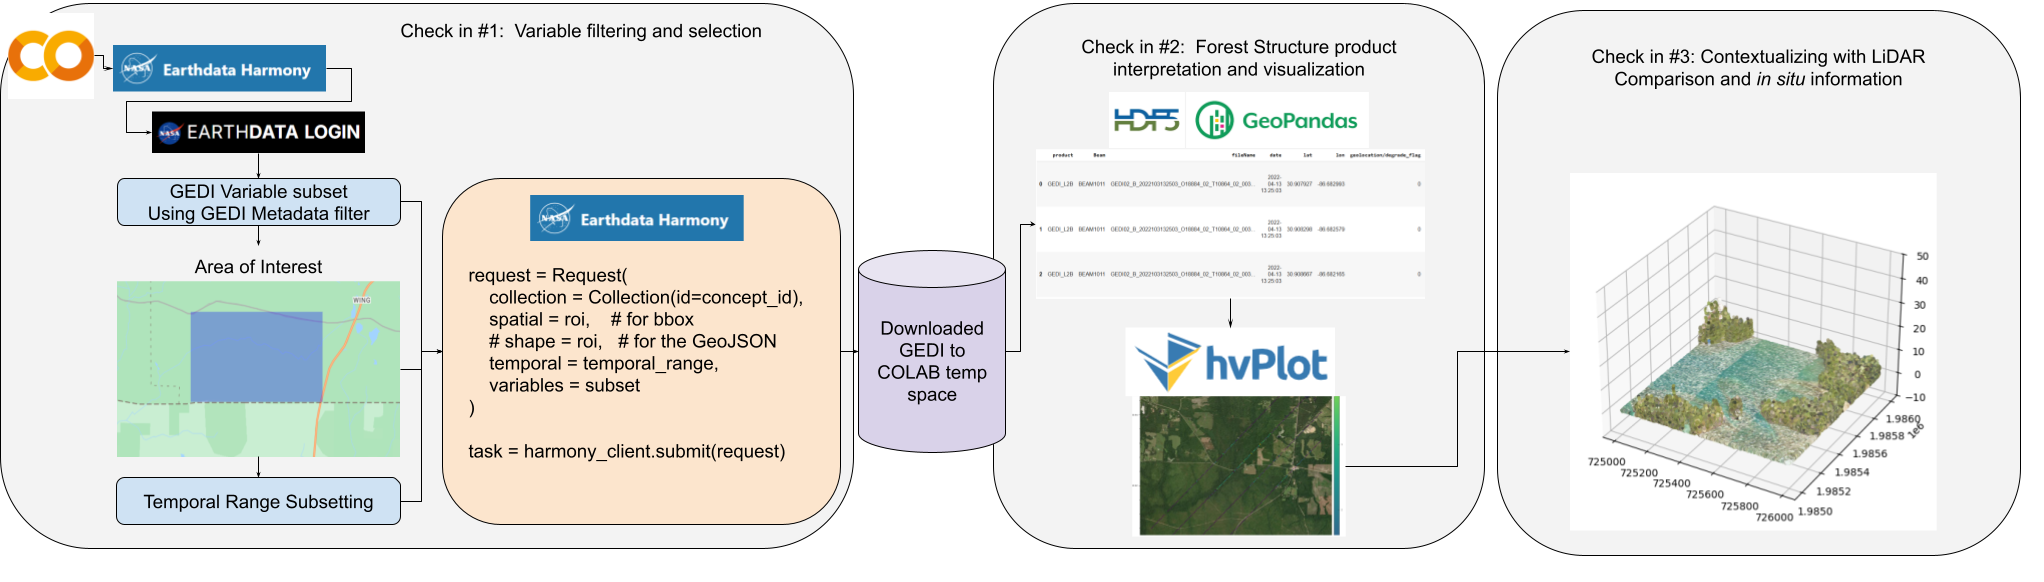

Link to editable workflow (to be removed at the end) https://docs.google.com/drawings/d/1q49Oa-y9W5X25_Qijg0IuSczzcVrcOX5mVfiyIO_UmE/edit

Load the needed packages

In [ ]:

from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
import h5py
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import pandas as pd
import numpy as np
import os
from IPython.display import JSON
from shapely.geometry import Point
import hvplot.pandas
import folium
from folium import GeoJson
from IPython.display import display, HTML
import requests
from io import StringIO
from datetime import datetime
import seaborn as sns
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
import textwrap
from mpl_toolkits.mplot3d import Axes3D
# gv.extension('bokeh', 'matplotlib')
from holoviews import opts
import shapely
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

os.chdir('../../')

## Authenticate

Pause here and set up your arorund and have your username and password ready for this next section. See the [EarthData Login](https://urs.earthdata.nasa.gov/) if you dont have an account yet.

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials stored in a .netrc file and allows users to type their credentials and persist them to a .netrc file if one does not exist.

In [ ]:
auth = earthaccess.login(persist=True)
# auth.token

Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object.

In [ ]:
harmony_client = Client(auth=(auth.username, auth.password))

# Visualize our Areas of intres (AOI)

Add relivant biophysical and forest informaiton regarind these sites see  the folder here with the docs to support this: https://drive.google.com/drive/folders/1WvBSUIHy6I05j8s1ZZRarho5qnG2wdnb

In [ ]:
# Bring in aois
geojson_urls = {
    # "SPB_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/SPB_AOI.geojson",
    # "Prescribed_Burn_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/prescribed_burn_aoi.geojson",
    "Sewanee_Domain": "https://raw.githubusercontent.com/MayerT1/Prep_GEDI/main/AOI/Sewanee_DL_project_bounds.geojson",
    # "PaintRockAOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/PaintRockAOI.geojson"
}

In [ ]:
# Load GeoJSONs into GeoDataFrames and store map HTML
geojson_gdfs = {}
maps_html = []

def create_map_and_gdf(name, url):
    # Get GeoJSON from URL
    geojson_data = requests.get(url).json()

    # Create GeoDataFrame
    gdf = gp.GeoDataFrame.from_features(geojson_data["features"])
    geojson_gdfs[name] = gdf

    # Determine map center
    coords = geojson_data['features'][0]['geometry']['coordinates']
    geom_type = geojson_data['features'][0]['geometry']['type']

    if geom_type == "Polygon":
        coords = coords[0]
    elif geom_type == "MultiPolygon":
        coords = coords[0][0]
    else:
        raise ValueError(f"Unsupported geometry type: {geom_type}")

    lat = sum(pt[1] for pt in coords) / len(coords)
    lon = sum(pt[0] for pt in coords) / len(coords)

    # Create map
    fmap = folium.Map(location=[lat, lon], zoom_start=13, tiles="OpenStreetMap")
    folium.GeoJson(geojson_data, name=name).add_to(fmap)

    # Return rendered HTML
    return fmap._repr_html_()

# Generate maps and GeoDataFrames
for name, url in geojson_urls.items():
    html_map = create_map_and_gdf(name, url)
    maps_html.append(html_map)


In [ ]:
# Display maps side by side
html = f"""
<div style="display: flex; flex-wrap: wrap;">
    {''.join([f'<div style="flex: 1; min-width: 400px; margin: 5px;">{m}</div>' for m in maps_html])}
</div>
"""
display(HTML(html))

In [ ]:
##Pull out the geopanda dataframes
# SPB_AOI = geojson_gdfs["SPB_AOI"]
# Prescribed_Burn_AOI = geojson_gdfs["Prescribed_Burn_AOI"]
Sewanee_Domain = geojson_gdfs["Sewanee_Domain"]
# PaintRock_AOI = geojson_gdfs["PaintRockAOI"]

In [ ]:
# Store all bbox objects in a dictionary for later use
bbox_dict = {}

for name, url in geojson_urls.items():
    gdf = gp.read_file(url)
    minx, miny, maxx, maxy = gdf.total_bounds
    bbox = BBox(minx, miny, maxx, maxy)
    bbox_dict[f"{name}_roi"] = bbox

bbox_dict


{'Sewanee_Domain_roi': BBox: West:-85.98985851794494, South:35.12704695073614, East:-85.85713664512146, North:35.23574346765027}

## Get the GEDI Collections Harmony Capabilities

First lets investigate what capabilites Harmony has to request data. Using hte short name `'GEDI02_B'`
('GEDI02_A', 'GEDI02_B', 'GEDI01_B')

view informaiton such as `conceptId` such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.

products of intrest: https://docs.google.com/spreadsheets/d/1Uvls3Oxn_jSmTyaSoWadQrS8tZSWyUGYai7etUoALLc/edit?gid=0#gid=0

In [ ]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "temporalSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_al

## Create a Harmony Request

There are several parameters that can be used for the Harmony request. See [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details.



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository [(CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections.

Below, `concept_id` is saved to a variable.  

In [ ]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']
print("concept_id:", concept_id)

GEDI02_B , C2142776747-LPCLOUD
concept_id: C2142776747-LPCLOUD


### GEDI Variable Subset

Take time to explore GEDI variables of importance via the [GEDI l2b dictionary](https://lpdaac.usgs.gov/documents/980/gedi_l2b_dictionary_P003_v2.html)

In [ ]:
#See the append_field.txt which hasd a long dictionary of the fields and products of GEDI
#This ictionary will be used to subset our variables of intrest
#Notice this includes'GEDI01_B','GEDI02_A', and 'GEDI02_B'

append_url = "https://raw.githubusercontent.com/MayerT1/Prep_GEDI/main/append_field.txt"
append_text = requests.get(append_url).text

start_index = append_text.find("{")
end_index = append_text.rfind("}") + 1
dict_str = append_text[start_index:end_index]

append_dict = eval(dict_str)

In [ ]:
#Display the dictionary we will use to subset later
append_dict

{'GEDI_L1B': ['geolocation/altitude_instrument',
  'geolocation/local_beam_elevation',
  'tx_sample_start_index',
  'nsemean_odd',
  'ancillary/master_time_epoch',
  'noise_stddev_corrected',
  'tx_pulseflag',
  'geolocation/longitude_bin0_error',
  'selection_stretchers_x',
  'nsemean_even',
  'geolocation/latitude_instrument',
  'geolocation/digital_elevation_model',
  'geolocation/longitude_instrument_error',
  'geolocation/longitude_lastbin_error',
  'tx_egsigma',
  'geolocation/neutat_delay_total_bin0',
  'rx_energy',
  'master_frac',
  'rx_sample_count',
  'rxwaveform',
  'tx_gloc',
  'ancillary/mean_samples',
  'geolocation/longitude_instrument',
  'tx_eggamma_error',
  'rx_offset',
  'tx_egbias_error',
  'geolocation/bounce_time_offset_lastbin',
  'all_samples_sum',
  'geophys_corr/tide_load',
  'geolocation/solar_azimuth',
  'geolocation/mean_sea_surface',
  'geolocation/neutat_delay_total_lastbin',
  'th_left_used',
  'rx_sample_start_index',
  'geophys_corr/tide_ocean',
  'g

In [ ]:
# print only the dictionary fo avaible GEDI 2 B products to explore
gedi_l2b = append_dict.get('GEDI_L2B', {})

# Step 4: Print items under 'GEDI_L2B'
print("Items under 'GEDI_L2B':")
for item in gedi_l2b:
    print(item)

Items under 'GEDI_L2B':
rx_processing/rg_eg_flag_a4
rx_processing/rg_eg_gamma_error_a5
rx_processing/rg_eg_gamma_error_a1
rx_processing/rg_error_a3
rx_processing/rg_eg_amplitude_a2
geolocation/local_beam_elevation
ancillary/rg_eg_constraint_center_buffer
rx_processing/rx_energy_a6
ancillary/tx_noise_stddev_multiplier
pgap_theta_z
rx_processing/rg_eg_center_error_a5
rx_processing/pgap_theta_a4
land_cover_data/modis_nonvegetated
geolocation/longitude_bin0_error
rx_processing/rg_error_a1
geolocation/elev_highestreturn
land_cover_data/landsat_water_persistence
land_cover_data/leaf_on_doy
rx_processing/algorithmrun_flag_a5
geolocation/lon_lowestmode
rx_processing/rx_energy_a4
geolocation/digital_elevation_model
rhov
rx_processing/rg_a5
rx_processing/rg_error_a2
geolocation/longitude_lastbin_error
rx_processing/rg_a6
rx_processing/rg_eg_gamma_a1
l2b_quality_flag
rx_processing/rg_eg_amplitude_error_a4
rx_processing/rg_eg_amplitude_a3
rx_processing/pgap_theta_error_a3
land_cover_data/leaf_off_

Select your variables of intrest

In [ ]:
#Selecting the 'GEDI02_B' of intrest to then be downloaded
#subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model','geolocation/elev_lowestmode','geolocation/elev_highestreturn','l2b_quality_flag','rh100','fhd_normal','cover','cover_z','pai','pai_z','pavd_z','rhov','omega','land_cover_data/pft_class']


# #Selecting the 'GEDI02_B' of intrest to then be downloaded
# subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model','geolocation/elev_lowestmode','geolocation/elev_highestreturn','l2b_quality_flag','rh100','fhd_normal','pai'] #'cover','cover_z','pai','pai_z','pavd_z','rhov','omega','land_cover_data/pft_class']


subset_L2B =  ['geolocation/lat_lowestmode','geolocation/lon_lowestmode','geolocation/solar_elevation','geolocation/local_beam_elevation','selected_l2a_algorithm','geolocation/degrade_flag','l2b_quality_flag','geolocation/digital_elevation_model','geolocation/elev_lowestmode','geolocation/elev_highestreturn', 'rh100','num_detectedmodes', 'sensitivity','land_cover_data/leaf_off_flag','/geolocation/solar_elevation','pgap_theta_z', 'pai', 'pai_z', 'fhd_normal', 'pavd_z', 'cover','cover_z','pgap_theta','pgap_theta_error','rhov','rhov_error','rhog', 'rhog_error']

In [ ]:
subset_L2B

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/solar_elevation',
 'geolocation/local_beam_elevation',
 'selected_l2a_algorithm',
 'geolocation/degrade_flag',
 'l2b_quality_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/elev_highestreturn',
 'rh100',
 'num_detectedmodes',
 'sensitivity',
 'land_cover_data/leaf_off_flag',
 '/geolocation/solar_elevation',
 'pgap_theta_z',
 'pai',
 'pai_z',
 'fhd_normal',
 'pavd_z',
 'cover',
 'cover_z',
 'pgap_theta',
 'pgap_theta_error',
 'rhov',
 'rhov_error',
 'rhog',
 'rhog_error']

In [ ]:
### filter those varibales ofintrest out of the larger list
selected_L2B = []
for s in subset_L2B:
    my_var = [v for v in gedi_l2b if v.endswith(f'{s}')]
    if len(my_var) == 1:
        selected_L2B.append(my_var[0])

    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]

        for l in my_var:
            if l not in selected_L2B:
                selected_L2B.append(l)

selected_L2B

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/solar_elevation',
 'geolocation/local_beam_elevation',
 'selected_l2a_algorithm',
 'geolocation/degrade_flag',
 'l2b_quality_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/elev_highestreturn',
 'rh100',
 'num_detectedmodes',
 'sensitivity',
 'land_cover_data/leaf_off_flag',
 'pgap_theta_z',
 'pai',
 'pai_z',
 'fhd_normal',
 'pavd_z',
 'cover',
 'cover_z',
 'pgap_theta',
 'pgap_theta_error',
 'rhov',
 'rhov_error',
 'rhog',
 'rhog_error']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [ ]:
#Selecting a few beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']


In [ ]:
#Append our beams of intrest to our variables of intrest
#the subset list will then be used throughout
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in selected_L2B]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/solar_elevation',
 '/BEAM0101/geolocation/local_beam_elevation',
 '/BEAM0101/selected_l2a_algorithm',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/rh100',
 '/BEAM0101/num_detectedmodes',
 '/BEAM0101/sensitivity',
 '/BEAM0101/land_cover_data/leaf_off_flag',
 '/BEAM0101/pgap_theta_z',
 '/BEAM0101/pai',
 '/BEAM0101/pai_z',
 '/BEAM0101/fhd_normal',
 '/BEAM0101/pavd_z',
 '/BEAM0101/cover',
 '/BEAM0101/cover_z',
 '/BEAM0101/pgap_theta',
 '/BEAM0101/pgap_theta_error',
 '/BEAM0101/rhov',
 '/BEAM0101/rhov_error',
 '/BEAM0101/rhog',
 '/BEAM0101/rhog_error',
 '/BEAM0110/geolocation/lat_lowestmode',
 '/BEAM0110/geolocation/lon_lowestmode',
 '/BEAM0110/geolocation/solar_elevation',
 '/BEAM0110/geolocation/local_beam_elevati

# Create Request Task and download spatially and vairable subseted H5 Files

These code block creates request tasks via harmony and downloads them to the set directories.
The AOI, time period, and subset variables are used to create the the request


In [ ]:
# # Define temporal range
# temporal_range = {'start': datetime(2019, 4, 1),
#                   'stop': datetime(2024, 12, 30)}

In [ ]:
# # Corresponding output directories
# output_dirs = [
#     # '/content/Module_2_GEDI_L2b/SPB_AOI',
#     # '/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI',
#     # '/content/Module_2_GEDI_L2b/PaintRock_AOI',
#     # '/content/Module_2_GEDI_L2b/Sewanee_Domain'
#     '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target'
# ]

In [ ]:
# # Loop through paired spatial ROIs and directories
# for (spatial, out_dir) in zip(bbox_dict.keys(), output_dirs):
#     print(f"\nSubmitting request for: {out_dir}")

#     request = Request(
#         collection=Collection(id=concept_id),
#         spatial=bbox_dict[spatial],  # Use the corresponding BBox from the dictionary
#         temporal=temporal_range,
#         variables=subset
#     )

#     print("Check if the request payload is valid:", request.is_valid())
#     print(request.__dict__)

#     task = harmony_client.submit(request)
#     print(f'Harmony request ID: {task}')

#     print('Processing your Harmony request:')
#     task_json = harmony_client.result_json(task, show_progress=True)

#     results = harmony_client.download_all(task, directory=out_dir, overwrite=True)
#     file_names = [f.result() for f in results]

#     print(f"Download completed for {out_dir}")


dev loop the harmoy api request

In [ ]:
from datetime import datetime, timedelta
import os
from harmony import BBox, Request, Collection

# --- CONFIG ---
num_chunks = 10
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

# Define temporal range
start_date = datetime(2019, 4, 1)
end_date = datetime(2024, 12, 30)
total_days = (end_date - start_date).days
chunk_size = total_days // num_chunks

# Loop through each AOI and its output directory
for (spatial, out_dir) in zip(bbox_dict.keys(), output_dirs):
    print(f"\n🔹 Starting downloads for AOI: {spatial}")

    # Loop through each beam
    for beam in beams:
        print(f"\n➡️ Beam: {beam}")

        # Filter your subset list for the current beam
        subset_beam = [v for v in subset if f"/{beam}/" in v]

        # Make sure we have output folders for this beam
        beam_out_dir = os.path.join(out_dir, beam)
        os.makedirs(beam_out_dir, exist_ok=True)

        # Split time range into N chunks
        for i in range(num_chunks):
            chunk_start = start_date + timedelta(days=i * chunk_size)
            chunk_end = start_date + timedelta(days=(i + 1) * chunk_size)
            if chunk_end > end_date:
                chunk_end = end_date

            temporal_chunk = {'start': chunk_start, 'stop': chunk_end}

            # Create a subfolder per chunk for better organization
            chunk_folder_name = f"{beam}_chunk_{i+1:02d}_{chunk_start.date()}_{chunk_end.date()}"
            chunk_out_dir = os.path.join(beam_out_dir, chunk_folder_name)
            os.makedirs(chunk_out_dir, exist_ok=True)

            print(f"\n🕒 {beam} | Chunk {i+1}/{num_chunks}: {chunk_start.date()} → {chunk_end.date()}")

            try:
                request = Request(
                    collection=Collection(id=concept_id),
                    spatial=bbox_dict[spatial],
                    temporal=temporal_chunk,
                    variables=subset_beam
                )

                if not request.is_valid():
                    print(f"⚠️ Skipping invalid request for {beam} chunk {i+1}")
                    continue

                print(f"Submitting Harmony request for {beam} chunk {i+1}")
                task = harmony_client.submit(request)

                print("⏳ Waiting for Harmony task to complete...")
                task_json = harmony_client.result_json(task, show_progress=True)

                print(f"⬇️ Downloading results to: {chunk_out_dir}")
                results = harmony_client.download_all(task, directory=chunk_out_dir, overwrite=True)

                file_names = [f.result() for f in results]
                print(f"✅ Download completed for {beam} chunk {i+1}")

            except Exception as e:
                print(f"❌ Error with {beam} chunk {i+1}: {e}")



🔹 Starting downloads for AOI: Sewanee_Domain_roi

➡️ Beam: BEAM0101

🕒 BEAM0101 | Chunk 1/10: 2019-04-01 → 2019-10-28
Submitting Harmony request for BEAM0101 chunk 1
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361193_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361194_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361195_GEDI02_B_2019210205202_O03556_02_T00995_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0101 chunk 1

🕒 BEAM0101 | Chunk 2/10: 2019-10-28 → 2020-05-25
Submitting Harmony request for BEAM0101 chunk 2
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_02_2019-10-28_2020-05-25
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_02_2019-10-28_2020-05-25/118361419_GEDI02_B_2019312044317_O05128_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_02_2019-10-28_2020-05-25/118361420_GEDI02_B_2019337015939_O05514_03_T01887_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0101 chunk 2

🕒 BEAM0101 | Chunk 3/10: 2020-05-25 → 2020-12-21
Submitting Harmony request for BEAM0101 chunk 3
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_03_2020-05-25_2020-12-21
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_03_2020-05-25_2020-12-21/118361549_GEDI02_B_2020182144232_O08778_03_T00311_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_03_2020-05-25_2020-12-21/118361550_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0101 chunk 3

🕒 BEAM0101 | Chunk 4/10: 2020-12-21 → 2021-07-19
Submitting Harmony request for BEAM0101 chunk 4
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_04_2020-12-21_2021-07-19
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_04_2020-12-21_2021-07-19/118361792_GEDI02_B_2021131101046_O13658_03_T04580_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_04_2020-12-21_2021-07-19/118361793_GEDI02_B_2021135083748_O13719_03_T08849_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_04_2020-12-21_2021-07-19/118361794_GEDI02_B_2021139070445_O13780_03_T06003_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0101 chunk 4

🕒 BEAM0101 | Chunk 5/10: 2021-07-19 → 2022-02-14
Submitting Harmony request for BEAM0101 chunk 5
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_05_2021-07-19_2022-02-14
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_05_2021-07-19_2022-02-14/118362066_GEDI02_B_2021232110553_O15224_02_T11109_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_05_2021-07-19_2022-02-14/118362069_GEDI02_B_2021298160332_O16250_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_05_2021-07-19_2022-02-14/118362070_GEDI02_B_2022016072349_O17531_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_05_2021-07-19_2022-02-14/118362068_GEDI02_B_2021288125533_O16093_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDriv

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_06_2022-02-14_2022-09-12
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_06_2022-02-14_2022-09-12/118362198_GEDI02_B_2022068034341_O18335_02_T00995_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_06_2022-02-14_2022-09-12/118362201_GEDI02_B_2022177153027_O20033_03_T01887_02_003_02_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_06_2022-02-14_2022-09-12/118362197_GEDI02_B_2022062130418_O18248_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_06_2022-02-14_2022-09-12/118362199_GEDI02_B_2022110105831_O18991_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDriv

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_07_2022-09-12_2023-04-10
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_07_2022-09-12_2023-04-10/118362389_GEDI02_B_2022352181058_O22749_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_07_2022-09-12_2023-04-10/118362387_GEDI02_B_2022289120454_O21768_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_07_2022-09-12_2023-04-10/118362390_GEDI02_B_2022358084911_O22836_02_T06687_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_07_2022-09-12_2023-04-10/118362391_GEDI02_B_2023023204458_O23309_02_T08110_02_003_01_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_09_2023-11-06_2024-06-03
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_09_2023-11-06_2024-06-03/118362492_GEDI02_B_2024150175955_O30938_02_T05264_02_004_01_V002_subsetted.h5
✅ Download completed for BEAM0101 chunk 9

🕒 BEAM0101 | Chunk 10/10: 2024-06-03 → 2024-12-30
Submitting Harmony request for BEAM0101 chunk 10
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_10_2024-06-03_2024-12-30
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_10_2024-06-03_2024-12-30/118362605_GEDI02_B_2024169103448_O31228_02_T05264_02_004_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_10_2024-06-03_2024-12-30/118362606_GEDI02_B_2024206031011_O31797_03_T04733_02_004_02_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_10_2024-06-03_2024-12-30/118362607_GEDI02_B_2024294160731_O33170_03_T08849_02_004_01_V002_subsetted.h5
✅ Download completed for BEAM0101 chunk 10

➡️ Beam: BEAM0110

🕒 BEAM0110 | Chunk 1/10: 2019-04-01 → 2019-10-28
Submitting Harmony request for BEAM0110 chunk 1
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_01_2019-04-01_2019-10-28
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_01_2019-04-01_2019-10-28/118362695_GEDI02_B_2019210205202_O03556_02_T00995_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_01_2019-04-01_2019-10-28/118362693_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_01_2019-04-01_2019-10-28/118362694_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0110 chunk 1

🕒 BEAM0110 | Chunk 2/10: 2019-10-28 → 2020-05-25
Submitting Harmony request for BEAM0110 chunk 2
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_02_2019-10-28_2020-05-25
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_02_2019-10-28_2020-05-25/118362879_GEDI02_B_2019312044317_O05128_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_02_2019-10-28_2020-05-25/118362880_GEDI02_B_2019337015939_O05514_03_T01887_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0110 chunk 2

🕒 BEAM0110 | Chunk 3/10: 2020-05-25 → 2020-12-21
Submitting Harmony request for BEAM0110 chunk 3
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_03_2020-05-25_2020-12-21
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_03_2020-05-25_2020-12-21/118363109_GEDI02_B_2020182144232_O08778_03_T00311_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_03_2020-05-25_2020-12-21/118363110_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0110 chunk 3

🕒 BEAM0110 | Chunk 4/10: 2020-12-21 → 2021-07-19
Submitting Harmony request for BEAM0110 chunk 4
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_04_2020-12-21_2021-07-19
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_04_2020-12-21_2021-07-19/118363287_GEDI02_B_2021131101046_O13658_03_T04580_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_04_2020-12-21_2021-07-19/118363288_GEDI02_B_2021135083748_O13719_03_T08849_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_04_2020-12-21_2021-07-19/118363289_GEDI02_B_2021139070445_O13780_03_T06003_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM0110 chunk 4

🕒 BEAM0110 | Chunk 5/10: 2021-07-19 → 2022-02-14
Submitting Harmony request for BEAM0110 chunk 5
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_05_2021-07-19_2022-02-14
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_05_2021-07-19_2022-02-14/118363532_GEDI02_B_2021232110553_O15224_02_T11109_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_05_2021-07-19_2022-02-14/118363534_GEDI02_B_2021288125533_O16093_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_05_2021-07-19_2022-02-14/118363535_GEDI02_B_2021298160332_O16250_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_05_2021-07-19_2022-02-14/118363536_GEDI02_B_2022016072349_O17531_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDriv

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_06_2022-02-14_2022-09-12
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_06_2022-02-14_2022-09-12/118363754_GEDI02_B_2022062130418_O18248_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_06_2022-02-14_2022-09-12/118363755_GEDI02_B_2022068034341_O18335_02_T00995_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_06_2022-02-14_2022-09-12/118363756_GEDI02_B_2022110105831_O18991_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_06_2022-02-14_2022-09-12/118363757_GEDI02_B_2022139064237_O19438_03_T04580_02_003_01_V002_subsetted.h5
/content/drive/MyDriv

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_07_2022-09-12_2023-04-10
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_07_2022-09-12_2023-04-10/118364210_GEDI02_B_2022289120454_O21768_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_07_2022-09-12_2023-04-10/118364212_GEDI02_B_2022352181058_O22749_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_07_2022-09-12_2023-04-10/118364213_GEDI02_B_2022358084911_O22836_02_T06687_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_07_2022-09-12_2023-04-10/118364214_GEDI02_B_2023023204458_O23309_02_T08110_02_003_01_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_09_2023-11-06_2024-06-03
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_09_2023-11-06_2024-06-03/118364469_GEDI02_B_2024150175955_O30938_02_T05264_02_004_01_V002_subsetted.h5
✅ Download completed for BEAM0110 chunk 9

🕒 BEAM0110 | Chunk 10/10: 2024-06-03 → 2024-12-30
Submitting Harmony request for BEAM0110 chunk 10
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_10_2024-06-03_2024-12-30
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_10_2024-06-03_2024-12-30/118364580_GEDI02_B_2024169103448_O31228_02_T05264_02_004_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_10_2024-06-03_2024-12-30/118364581_GEDI02_B_2024206031011_O31797_03_T04733_02_004_02_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0110/BEAM0110_chunk_10_2024-06-03_2024-12-30/118364582_GEDI02_B_2024294160731_O33170_03_T08849_02_004_01_V002_subsetted.h5
✅ Download completed for BEAM0110 chunk 10

➡️ Beam: BEAM1000

🕒 BEAM1000 | Chunk 1/10: 2019-04-01 → 2019-10-28
Submitting Harmony request for BEAM1000 chunk 1
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_01_2019-04-01_2019-10-28
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_01_2019-04-01_2019-10-28/118364834_GEDI02_B_2019122150008_O02186_03_T04733_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_01_2019-04-01_2019-10-28/118364835_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_01_2019-04-01_2019-10-28/118364836_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_01_2019-04-01_2019-10-28/118364837_GEDI02_B_2019210205202_O03556_02_T00995_02_003_01_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_02_2019-10-28_2020-05-25
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_02_2019-10-28_2020-05-25/118365105_GEDI02_B_2019312044317_O05128_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_02_2019-10-28_2020-05-25/118365106_GEDI02_B_2019337015939_O05514_03_T01887_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM1000 chunk 2

🕒 BEAM1000 | Chunk 3/10: 2020-05-25 → 2020-12-21
Submitting Harmony request for BEAM1000 chunk 3
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_03_2020-05-25_2020-12-21
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_03_2020-05-25_2020-12-21/118365255_GEDI02_B_2020182144232_O08778_03_T00311_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_03_2020-05-25_2020-12-21/118365256_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM1000 chunk 3

🕒 BEAM1000 | Chunk 4/10: 2020-12-21 → 2021-07-19
Submitting Harmony request for BEAM1000 chunk 4
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_04_2020-12-21_2021-07-19
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_04_2020-12-21_2021-07-19/118365411_GEDI02_B_2021135083748_O13719_03_T08849_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_04_2020-12-21_2021-07-19/118365412_GEDI02_B_2021139070445_O13780_03_T06003_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM1000 chunk 4

🕒 BEAM1000 | Chunk 5/10: 2021-07-19 → 2022-02-14
Submitting Harmony request for BEAM1000 chunk 5
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_05_2021-07-19_2022-02-14
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_05_2021-07-19_2022-02-14/118365635_GEDI02_B_2021232110553_O15224_02_T11109_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_05_2021-07-19_2022-02-14/118365637_GEDI02_B_2021288125533_O16093_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_05_2021-07-19_2022-02-14/118365639_GEDI02_B_2022016072349_O17531_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_05_2021-07-19_2022-02-14/118365638_GEDI02_B_2021298160332_O16250_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDriv

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_06_2022-02-14_2022-09-12
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_06_2022-02-14_2022-09-12/118366034_GEDI02_B_2022062130418_O18248_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_06_2022-02-14_2022-09-12/118366035_GEDI02_B_2022068034341_O18335_02_T00995_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_06_2022-02-14_2022-09-12/118366036_GEDI02_B_2022110105831_O18991_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_06_2022-02-14_2022-09-12/118366038_GEDI02_B_2022177153027_O20033_03_T01887_02_003_02_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_07_2022-09-12_2023-04-10
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_07_2022-09-12_2023-04-10/118366450_GEDI02_B_2022289120454_O21768_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_07_2022-09-12_2023-04-10/118366452_GEDI02_B_2022352181058_O22749_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_07_2022-09-12_2023-04-10/118366453_GEDI02_B_2022358084911_O22836_02_T06687_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_07_2022-09-12_2023-04-10/118366454_GEDI02_B_2023023204458_O23309_02_T08110_02_003_01_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_09_2023-11-06_2024-06-03



There is no file to download.

Job status is successful with message: WorkItem warned: sds/trajectory-subsetter:0.3.8: No data found to process.


✅ Download completed for BEAM1000 chunk 9

🕒 BEAM1000 | Chunk 10/10: 2024-06-03 → 2024-12-30
Submitting Harmony request for BEAM1000 chunk 10
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_10_2024-06-03_2024-12-30
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_10_2024-06-03_2024-12-30/118366863_GEDI02_B_2024169103448_O31228_02_T05264_02_004_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_10_2024-06-03_2024-12-30/118366864_GEDI02_B_2024206031011_O31797_03_T04733_02_004_02_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1000/BEAM1000_chunk_10_2024-06-03_2024-12-30/118366865_GEDI02_B_2024294160731_O33170_03_T08849_02_004_01_V002_subsetted.h5
✅ Download completed for BEAM1000 chunk 10

➡️ Beam: BEAM1011

🕒 BEAM1011 | Chunk 1/10: 2019-04-01 → 2019-10-28
Submitting Harmony request for BEAM1011 chunk 1
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_01_2019-04-01_2019-10-28
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_01_2019-04-01_2019-10-28/118367097_GEDI02_B_2019122150008_O02186_03_T04733_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_01_2019-04-01_2019-10-28/118367098_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_01_2019-04-01_2019-10-28/118367099_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_01_2019-04-01_2019-10-28/118367100_GEDI02_B_2019210205202_O03556_02_T00995_02_003_01_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_02_2019-10-28_2020-05-25
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_02_2019-10-28_2020-05-25/118367327_GEDI02_B_2019337015939_O05514_03_T01887_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM1011 chunk 2

🕒 BEAM1011 | Chunk 3/10: 2020-05-25 → 2020-12-21
Submitting Harmony request for BEAM1011 chunk 3
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_03_2020-05-25_2020-12-21
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_03_2020-05-25_2020-12-21/118367423_GEDI02_B_2020182144232_O08778_03_T00311_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_03_2020-05-25_2020-12-21/118367424_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM1011 chunk 3

🕒 BEAM1011 | Chunk 4/10: 2020-12-21 → 2021-07-19
Submitting Harmony request for BEAM1011 chunk 4
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_04_2020-12-21_2021-07-19
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_04_2020-12-21_2021-07-19/118367527_GEDI02_B_2021135083748_O13719_03_T08849_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_04_2020-12-21_2021-07-19/118367528_GEDI02_B_2021139070445_O13780_03_T06003_02_003_01_V002_subsetted.h5
✅ Download completed for BEAM1011 chunk 4

🕒 BEAM1011 | Chunk 5/10: 2021-07-19 → 2022-02-14
Submitting Harmony request for BEAM1011 chunk 5
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_05_2021-07-19_2022-02-14
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_05_2021-07-19_2022-02-14/118367749_GEDI02_B_2021238154634_O15320_03_T07579_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_05_2021-07-19_2022-02-14/118367750_GEDI02_B_2021288125533_O16093_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_05_2021-07-19_2022-02-14/118367751_GEDI02_B_2021298160332_O16250_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_05_2021-07-19_2022-02-14/118367752_GEDI02_B_2022016072349_O17531_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDriv

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_06_2022-02-14_2022-09-12
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_06_2022-02-14_2022-09-12/118368100_GEDI02_B_2022062130418_O18248_03_T10425_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_06_2022-02-14_2022-09-12/118368101_GEDI02_B_2022068034341_O18335_02_T00995_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_06_2022-02-14_2022-09-12/118368102_GEDI02_B_2022110105831_O18991_02_T02571_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_06_2022-02-14_2022-09-12/118368104_GEDI02_B_2022177153027_O20033_03_T01887_02_003_02_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_07_2022-09-12_2023-04-10
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_07_2022-09-12_2023-04-10/118368784_GEDI02_B_2022289120454_O21768_02_T09533_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_07_2022-09-12_2023-04-10/118368786_GEDI02_B_2022352181058_O22749_03_T07426_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_07_2022-09-12_2023-04-10/118368787_GEDI02_B_2022358084911_O22836_02_T06687_02_003_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_07_2022-09-12_2023-04-10/118368788_GEDI02_B_2023023204458_O23309_02_T08110_02_003_01_V002_subsetted.h5
✅ Download completed 

 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_09_2023-11-06_2024-06-03



There is no file to download.

Job status is successful with message: WorkItem warned: sds/trajectory-subsetter:0.3.8: No data found to process.


✅ Download completed for BEAM1011 chunk 9

🕒 BEAM1011 | Chunk 10/10: 2024-06-03 → 2024-12-30
Submitting Harmony request for BEAM1011 chunk 10
⏳ Waiting for Harmony task to complete...


 [ Processing: 100% ] |###################################################| [|]


⬇️ Downloading results to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_10_2024-06-03_2024-12-30
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_10_2024-06-03_2024-12-30/118369233_GEDI02_B_2024169103448_O31228_02_T05264_02_004_01_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_10_2024-06-03_2024-12-30/118369234_GEDI02_B_2024206031011_O31797_03_T04733_02_004_02_V002_subsetted.h5
/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM1011/BEAM1011_chunk_10_2024-06-03_2024-12-30/118369235_GEDI02_B_2024294160731_O33170_03_T08849_02_004_01_V002_subsetted.h5
✅ Download completed for BEAM1011 chunk 10


In [1]:
## confirm files are in the right spots
!find /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target

find: ‘/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target’: No such file or directory


filter list: https://docs.google.com/document/d/1nm0qn_E6_dGM2g5_mu4utRip6VzC0QUF3Z_lmtxP4Ow/edit?tab=t.0

In [ ]:
import h5py
import os
import glob
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# =========================================
# CONFIG
# =========================================
data_dir = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target'
output_dir = os.path.join(data_dir, 'filtered_csvs')
os.makedirs(output_dir, exist_ok=True)

beam_groups = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

variables = [
    'geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/solar_elevation',
    'geolocation/local_beam_elevation', 'selected_l2a_algorithm', 'geolocation/degrade_flag',
    'l2a_quality_flag', 'l2b_quality_flag', 'geolocation/digital_elevation_model',
    'geolocation/elev_lowestmode', 'geolocation/elev_highestreturn', 'rh100', 'num_detectedmodes',
    'sensitivity', 'land_cover_data/leaf_off_flag', 'pgap_theta_z', 'pai', 'pai_z', 'fhd_normal',
    'pavd_z', 'cover', 'cover_z', 'pgap_theta', 'pgap_theta_error', 'rhov', 'rhov_error',
    'rhog', 'rhog_error'
]

resample_distance = 25

# =========================================
# FUNCTIONS
# =========================================
def resample_25m(df):
    if df.empty:
        return df
    selected_rows = [df.iloc[0]]
    last_coord = (df.iloc[0]['lat'], df.iloc[0]['lon'])

    for _, row in df.iterrows():
        current_coord = (row['lat'], row['lon'])
        dist = geodesic(last_coord, current_coord).meters
        if dist >= resample_distance:
            selected_rows.append(row)
            last_coord = current_coord

    return pd.DataFrame(selected_rows)


def apply_complex_filters_with_logs(df, beam):
    logs = {}
    total = len(df)
    logs['initial'] = total

    df.replace(-9999, np.nan, inplace=True)

    # Core quality filters
    df_qc = df[
        (df.get('l2a_quality_flag', 1) == 1) &
        (df.get('l2b_quality_flag', 1) == 1) &
        (df.get('degrade_flag', 0) == 0)
    ]
    logs['after_qc'] = len(df_qc)

    # Solar elevation
    if 'solar_elevation' in df_qc.columns:
        df_solar = df_qc[df_qc['solar_elevation'] < 0]
    else:
        df_solar = df_qc
    logs['after_solar'] = len(df_solar)

    # Phenology / leaf-on
    if 'leaf_off_flag' in df_solar.columns:
        df_leaf = df_solar[df_solar['leaf_off_flag'] == 0]
    else:
        df_leaf = df_solar
    logs['after_leaf_on'] = len(df_leaf)

    # Signal penetration
    if 'sensitivity' in df_leaf.columns:
        df_sens = df_leaf[df_leaf['sensitivity'] >= 0.95]
    else:
        df_sens = df_leaf
    logs['after_sensitivity'] = len(df_sens)

    # Topography filter
    if all(col in df_sens.columns for col in ['digital_elevation_model', 'elev_lowestmode']):
        df_sens['dem_diff'] = df_sens['elev_lowestmode'] - df_sens['digital_elevation_model']
        df_topo = df_sens[df_sens['dem_diff'].between(-20, 20)]
    else:
        df_topo = df_sens
    logs['after_topography'] = len(df_topo)

    # Elevation sanity
    if all(col in df_topo.columns for col in ['elev_highestreturn', 'elev_lowestmode']):
        df_elev = df_topo[(df_topo['elev_highestreturn'] - df_topo['elev_lowestmode']).between(0, 100)]
    else:
        df_elev = df_topo
    logs['after_elevation'] = len(df_elev)

    # Final cleaning
    if 'num_detectedmodes' in df_elev.columns:
        df_final = df_elev[df_elev['num_detectedmodes'] > 0]
    else:
        df_final = df_elev
    logs['after_num_detectedmodes'] = len(df_final)

    return df_final, logs


# =========================================
# MAIN LOOP
# =========================================
h5_files = [os.path.join(root, file)
            for root, _, files in os.walk(data_dir)
            for file in files if file.endswith('.h5')]

print(f"Found {len(h5_files)} GEDI files to process.\n")

for h5_file in h5_files:
    print(f"Processing {h5_file}")
    with h5py.File(h5_file, 'r') as f:
        for beam in beam_groups:
            if beam not in f:
                continue

            beam_data = {}
            for var in variables:
                try:
                    data = f[beam][var][:]
                    if data.ndim > 1:
                        data = data.mean(axis=1)
                    beam_data[var.split('/')[-1]] = data
                except KeyError:
                    continue

            if 'lat_lowestmode' not in beam_data or 'lon_lowestmode' not in beam_data:
                print(f"⚠️ Skipping {beam} — missing coordinates.")
                continue

            main_len = len(beam_data['lat_lowestmode'])
            beam_data_filtered = {k: v for k, v in beam_data.items() if len(v) == main_len}

            df = pd.DataFrame(beam_data_filtered)
            df.rename(columns={'lat_lowestmode': 'lat', 'lon_lowestmode': 'lon'}, inplace=True)

            df_filtered, filter_logs = apply_complex_filters_with_logs(df, beam)

            # Log shot counts per filter
            print(f"Beam {beam} filter counts: {filter_logs}")

            df_resampled = resample_25m(df_filtered)

            if not df_resampled.empty:
                base_name = os.path.splitext(os.path.basename(h5_file))[0]
                out_path = os.path.join(output_dir, f"{base_name}_{beam}_filtered.csv")
                df_resampled.to_csv(out_path, index=False)
                print(f"✅ Saved: {out_path} ({len(df_resampled)} shots)\n")
            else:
                print(f"⚠️ No valid data left for {beam} in {os.path.basename(h5_file)}.\n")


Found 107 GEDI files to process.

Processing /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361193_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
Beam BEAM0101 filter counts: {'initial': 247, 'after_qc': 0, 'after_solar': 0, 'after_leaf_on': 0, 'after_sensitivity': 0, 'after_topography': 0, 'after_elevation': 0, 'after_num_detectedmodes': 0}
⚠️ No valid data left for BEAM0101 in 118361193_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5.

Processing /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361194_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
Beam BEAM0101 filter counts: {'initial': 276, 'after_qc': 0, 'after_solar': 0, 'after_leaf_on': 0, 'after_sensitivity': 0, 'after_topography': 0, 'after_elevation': 0, 'after_num_detectedmodes': 0}
⚠️ No valid data l

dev

In [3]:
import h5py
import os
import glob
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# =========================================
# CONFIG
# =========================================
data_dir = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target'
output_dir = os.path.join(data_dir, 'filtered_csvs')
os.makedirs(output_dir, exist_ok=True)

beam_groups = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

variables = [
    'geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/solar_elevation',
    'geolocation/local_beam_elevation', 'selected_l2a_algorithm', 'geolocation/degrade_flag',
    'l2a_quality_flag', 'l2b_quality_flag', 'geolocation/digital_elevation_model',
    'geolocation/elev_lowestmode', 'geolocation/elev_highestreturn', 'rh100', 'num_detectedmodes',
    'sensitivity', 'land_cover_data/leaf_off_flag', 'pgap_theta_z', 'pai', 'pai_z', 'fhd_normal',
    'pavd_z', 'cover', 'cover_z', 'pgap_theta', 'pgap_theta_error', 'rhov', 'rhov_error',
    'rhog', 'rhog_error'
]

resample_distance = 25

# =========================================
# FUNCTIONS
# =========================================
def resample_25m(df):
    """Downsample points to ~25 m spacing along track."""
    if df.empty:
        return df
    selected_rows = [df.iloc[0]]
    last_coord = (df.iloc[0]['lat'], df.iloc[0]['lon'])

    for _, row in df.iterrows():
        current_coord = (row['lat'], row['lon'])
        dist = geodesic(last_coord, current_coord).meters
        if dist >= resample_distance:
            selected_rows.append(row)
            last_coord = current_coord

    return pd.DataFrame(selected_rows)


def apply_complex_filters_with_logs(df, beam):
    """Apply multi-step filters and record counts after each step."""
    logs = {}
    total = len(df)
    logs['initial'] = total

    df.replace(-9999, np.nan, inplace=True)

    # Core quality filters
    df_qc = df[
        (df.get('l2a_quality_flag', 1) == 1) &
        (df.get('l2b_quality_flag', 1) == 1) &
        (df.get('degrade_flag', 0) == 0)
    ]
    logs['after_qc'] = len(df_qc)

    # Solar elevation
    df_solar = df_qc[df_qc['solar_elevation'] < 0] if 'solar_elevation' in df_qc.columns else df_qc
    logs['after_solar'] = len(df_solar)

    # Phenology / leaf-on
    df_leaf = df_solar[df_solar['leaf_off_flag'] == 0] if 'leaf_off_flag' in df_solar.columns else df_solar
    logs['after_leaf_on'] = len(df_leaf)

    # Signal penetration
    df_sens = df_leaf[df_leaf['sensitivity'] >= 0.95] if 'sensitivity' in df_leaf.columns else df_leaf
    logs['after_sensitivity'] = len(df_sens)

    # Topography filter
    if all(col in df_sens.columns for col in ['digital_elevation_model', 'elev_lowestmode']):
        df_sens['dem_diff'] = df_sens['elev_lowestmode'] - df_sens['digital_elevation_model']
        df_topo = df_sens[df_sens['dem_diff'].between(-20, 20)]
    else:
        df_topo = df_sens
    logs['after_topography'] = len(df_topo)

    # Elevation sanity
    if all(col in df_topo.columns for col in ['elev_highestreturn', 'elev_lowestmode']):
        df_elev = df_topo[(df_topo['elev_highestreturn'] - df_topo['elev_lowestmode']).between(0, 100)]
    else:
        df_elev = df_topo
    logs['after_elevation'] = len(df_elev)

    # Final cleaning
    df_final = df_elev[df_elev['num_detectedmodes'] > 0] if 'num_detectedmodes' in df_elev.columns else df_elev
    logs['after_num_detectedmodes'] = len(df_final)

    return df_final, logs


# =========================================
# MAIN LOOP
# =========================================
h5_files = [os.path.join(root, file)
            for root, _, files in os.walk(data_dir)
            for file in files if file.endswith('.h5')]

print(f"Found {len(h5_files)} GEDI files to process.\n")

for h5_file in h5_files:
    print(f"Processing {h5_file}")
    with h5py.File(h5_file, 'r') as f:
        for beam in beam_groups:
            if beam not in f:
                continue

            beam_data = {}
            for var in variables:
                try:
                    data = f[beam][var][:]

                    # Keep full vertical profile for *_z variables
                    if data.ndim > 1 and var.split('/')[-1].endswith('_z'):
                        var_name = var.split('/')[-1]
                        for i in range(data.shape[1]):
                            beam_data[f"{var_name}_bin_{i}"] = data[:, i]
                        continue  # skip flattening
                    elif data.ndim > 1:
                        # For other multi-dim arrays, take mean per shot
                        data = data.mean(axis=1)

                    beam_data[var.split('/')[-1]] = data

                except KeyError:
                    continue

            # Skip if missing core coords
            if 'lat_lowestmode' not in beam_data or 'lon_lowestmode' not in beam_data:
                print(f"⚠️ Skipping {beam} — missing coordinates.")
                continue

            main_len = len(beam_data['lat_lowestmode'])
            beam_data_filtered = {k: v for k, v in beam_data.items() if len(v) == main_len}

            df = pd.DataFrame(beam_data_filtered)
            df.rename(columns={'lat_lowestmode': 'lat', 'lon_lowestmode': 'lon'}, inplace=True)

            # Apply filters
            df_filtered, filter_logs = apply_complex_filters_with_logs(df, beam)

            # Log shot counts per filter
            print(f"Beam {beam} filter counts: {filter_logs}")

            # Resample ~25m
            df_resampled = resample_25m(df_filtered)

            # Save
            if not df_resampled.empty:
                base_name = os.path.splitext(os.path.basename(h5_file))[0]
                out_path = os.path.join(output_dir, f"{base_name}_{beam}_filtered.csv")
                df_resampled.to_csv(out_path, index=False)
                print(f"✅ Saved: {out_path} ({len(df_resampled)} shots)\n")
            else:
                print(f"⚠️ No valid data left for {beam} in {os.path.basename(h5_file)}.\n")


Found 107 GEDI files to process.

Processing /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361193_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
Beam BEAM0101 filter counts: {'initial': 247, 'after_qc': 0, 'after_solar': 0, 'after_leaf_on': 0, 'after_sensitivity': 0, 'after_topography': 0, 'after_elevation': 0, 'after_num_detectedmodes': 0}
⚠️ No valid data left for BEAM0101 in 118361193_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5.

Processing /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/BEAM0101/BEAM0101_chunk_01_2019-04-01_2019-10-28/118361194_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
Beam BEAM0101 filter counts: {'initial': 276, 'after_qc': 0, 'after_solar': 0, 'after_leaf_on': 0, 'after_sensitivity': 0, 'after_topography': 0, 'after_elevation': 0, 'after_num_detectedmodes': 0}
⚠️ No valid data l

In [4]:
import os
import glob
import pandas as pd

# Path to the directory with all filtered CSVs
csv_dir = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs'
output_csv = os.path.join(csv_dir, 'GEDI_filtered_merged.csv')

# Recursively get all CSV files in csv_dir and its subdirectories
csv_files = glob.glob(os.path.join(csv_dir, '**', '*.csv'), recursive=True)

print(f"Found {len(csv_files)} filtered CSVs to merge.")

# List to hold DataFrames
df_list = []

for idx, file in enumerate(csv_files, 1):
    df = pd.read_csv(file)
    if df.empty:
        print(f"⚠️ Skipping empty file: {file}")
        continue

    filename = os.path.basename(file)
    # Extract beam ID: assumes last three elements of filename split by '_'
    beam_id = filename.split('_')[-3]

    df['beam'] = beam_id
    df['source_file'] = filename

    df_list.append(df)

    if idx % 20 == 0:
        print(f"Merged {idx}/{len(csv_files)} files...")

# Combine all into one DataFrame
merged_df = pd.concat(df_list, ignore_index=True)

# Reorder columns so 'beam' and 'source_file' appear first
cols = ['beam', 'source_file'] + [c for c in merged_df.columns if c not in ['beam', 'source_file']]
merged_df = merged_df[cols]

# Save merged CSV
merged_df.to_csv(output_csv, index=False)
print(f"✅ Merged CSV saved to: {output_csv}")


Found 12 filtered CSVs to merge.
✅ Merged CSV saved to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged CSV
csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
df = pd.read_csv(csv_path)

# # Preview columns
# print("Columns available:", df.columns.tolist())

# # Automatically select all numeric columns
# numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
# print(f"Numeric columns selected for plotting: {numeric_cols}")

# # Drop rows with missing or NaN values in numeric columns
# df_clean = df[numeric_cols].dropna()

# Pair plot
sns.pairplot(df, corner=True, plot_kws={'alpha': 0.3})
plt.suptitle('GEDI Observation Pair Plot', y=1.02)
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7dbe43554c20> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7dbe4371a160> (for post_execute):


KeyboardInterrupt: 

In [6]:
df.columns.tolist()

['beam',
 'source_file',
 'lat',
 'lon',
 'solar_elevation',
 'local_beam_elevation',
 'selected_l2a_algorithm',
 'degrade_flag',
 'l2b_quality_flag',
 'digital_elevation_model',
 'elev_lowestmode',
 'elev_highestreturn',
 'rh100',
 'num_detectedmodes',
 'sensitivity',
 'leaf_off_flag',
 'pai',
 'pai_z_bin_0',
 'pai_z_bin_1',
 'pai_z_bin_2',
 'pai_z_bin_3',
 'pai_z_bin_4',
 'pai_z_bin_5',
 'pai_z_bin_6',
 'pai_z_bin_7',
 'pai_z_bin_8',
 'pai_z_bin_9',
 'pai_z_bin_10',
 'pai_z_bin_11',
 'pai_z_bin_12',
 'pai_z_bin_13',
 'pai_z_bin_14',
 'pai_z_bin_15',
 'pai_z_bin_16',
 'pai_z_bin_17',
 'pai_z_bin_18',
 'pai_z_bin_19',
 'pai_z_bin_20',
 'pai_z_bin_21',
 'pai_z_bin_22',
 'pai_z_bin_23',
 'pai_z_bin_24',
 'pai_z_bin_25',
 'pai_z_bin_26',
 'pai_z_bin_27',
 'pai_z_bin_28',
 'pai_z_bin_29',
 'fhd_normal',
 'pavd_z_bin_0',
 'pavd_z_bin_1',
 'pavd_z_bin_2',
 'pavd_z_bin_3',
 'pavd_z_bin_4',
 'pavd_z_bin_5',
 'pavd_z_bin_6',
 'pavd_z_bin_7',
 'pavd_z_bin_8',
 'pavd_z_bin_9',
 'pavd_z_bin_10',
 

In [7]:
df

beam                                        source_file        lat  \
0     subsetted  118362200_GEDI02_B_2022139064237_O19438_03_T04...  35.143790   
1     subsetted  118362200_GEDI02_B_2022139064237_O19438_03_T04...  35.143436   
2     subsetted  118362200_GEDI02_B_2022139064237_O19438_03_T04...  35.143084   
3     subsetted  118362200_GEDI02_B_2022139064237_O19438_03_T04...  35.142734   
4     subsetted  118362200_GEDI02_B_2022139064237_O19438_03_T04...  35.142380   
...         ...                                                ...        ...   
1766   filtered                   GEDI_filtered_merged_summary.csv        NaN   
1767   filtered                   GEDI_filtered_merged_summary.csv        NaN   
1768   filtered                   GEDI_filtered_merged_summary.csv        NaN   
1769   filtered                   GEDI_filtered_merged_summary.csv        NaN   
1770   filtered                   GEDI_filtered_merged_summary.csv        NaN   

            lon  solar_elevation  local_beam_elevation  \
0    -85.989702       -28.266678              1.473616   
1    -85.989238       -28.266764              1.473616   
2    -85.988777       -28.266850              1.473616   
3    -85.988317       -28.266935              1.473616   
4    -85.987853       -28.267021              1.473616   
...         ...              ...                   ...   
1766        NaN              NaN                   NaN   
1767        NaN              NaN                   NaN   
1768        NaN              NaN                   NaN   
1769        NaN              NaN                   NaN   
1770        NaN              NaN                   NaN   

      selected_l2a_algorithm  degrade_flag  l2b_quality_flag  \
0                        2.0           0.0               1.0   
1                        2.0           0.0               1.0   
2                        2.0           0.0               1.0   
3                        2.0           0.0               1.0   
4                        2.0           0.0               1.0   
...                      ...           ...               ...   
1766                     NaN           NaN               NaN   
1767                     NaN           NaN               NaN   
1768                     NaN           NaN               NaN   
1769                     NaN           NaN               NaN   
1770                     NaN           NaN               NaN   

      digital_elevation_model  ...  pavd_z  cover_z        Unnamed: 0  count  \
0                  421.361786  ...     NaN      NaN               NaN    NaN   
1                  433.982147  ...     NaN      NaN               NaN    NaN   
2                  447.244324  ...     NaN      NaN               NaN    NaN   
3                  440.506836  ...     NaN      NaN               NaN    NaN   
4                  456.909363  ...     NaN      NaN               NaN    NaN   
...                       ...  ...     ...      ...               ...    ...   
1766                      NaN  ...     NaN      NaN        pgap_theta  872.0   
1767                      NaN  ...     NaN      NaN              rhov  872.0   
1768                      NaN  ...     NaN      NaN  pgap_theta_error  872.0   
1769                      NaN  ...     NaN      NaN              rhog  872.0   
1770                      NaN  ...     NaN      NaN          dem_diff  872.0   

      nans       mean        min        max       std  num_-9999  
0      NaN        NaN        NaN        NaN       NaN        NaN  
1      NaN        NaN        NaN        NaN       NaN        NaN  
2      NaN        NaN        NaN        NaN       NaN        NaN  
3      NaN        NaN        NaN        NaN       NaN        NaN  
4      NaN        NaN        NaN        NaN       NaN        NaN  
...    ...        ...        ...        ...       ...        ...  
1766   0.0   0.246156   0.022257   0.999161  0.249604        0.0  
1767   0.0   0.600000   0.600000   0.600000  0.000000        0.0  
1768   0

In [8]:
import pandas as pd
import numpy as np

# Load your merged filtered GEDI CSV
csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
df = pd.read_csv(csv_path)

# Replace strings or whitespace column names just in case
df.columns = df.columns.str.strip()

# Convert obvious fill values (-9999 etc.) to NaN
df.replace([-9999, -9999.0, -9998.999], np.nan, inplace=True)

# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number])

# Build summary table
summary = pd.DataFrame({
    'count': numeric_df.count(),
    'nans': numeric_df.isna().sum(),
    'mean': numeric_df.mean(),
    'min': numeric_df.min(),
    'max': numeric_df.max(),
    'std': numeric_df.std(),
})

# Add count of fill values (before conversion)
df_raw = pd.read_csv(csv_path)  # reload to count raw -9999 values
for col in numeric_df.columns:
    summary.loc[col, 'num_-9999'] = (df_raw[col] == -9999).sum() if col in df_raw.columns else 0

# Sort by number of missing values for easy QA
summary = summary.sort_values(by='nans', ascending=False)

# Display full table in Colab
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
display(summary)

# Optional: Save to CSV
summary_path = csv_path.replace('.csv', '_summary.csv')
summary.to_csv(summary_path)
print(f"✅ Summary saved to: {summary_path}")


count  nans     mean     min      max      std  \
rhog_error                   0  1771      NaN     NaN      NaN      NaN   
rhov_error                   0  1771      NaN     NaN      NaN      NaN   
mean                        25  1746  167.281 -85.938 2691.800  553.670   
std                         25  1746   37.274   0.000  704.535  140.907   
max                         25  1746  278.129 -85.858 5229.000 1049.309   
min                         25  1746   43.893 -85.990  344.000  115.140   
count                       27  1744  807.407   0.000  872.000  232.720   
nans                        27  1744   64.593   0.000  872.000  232.720   
num_-9999                   27  1744    0.000   0.000    0.000    0.000   
pai_z_bin_8                872   899    0.001  -0.000    0.184    0.009   
pai_z_bin_10               872   899    0.000  -0.000    0.026    0.001   
pai_z_bin_11               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_12               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_27               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_26               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_25               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_24               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_23               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_22               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_9                872   899    0.000  -0.000    0.061    0.002   
pai_z_bin_5                872   899    0.219  -0.000    2.035    0.337   
pai_z_bin_6                872   899    0.035  -0.000    1.039    0.120   
pai_z_bin_7                872   899    0.005  -0.000    0.388    0.029   
pai_z_bin_4                872   899    0.807  -0.000    3.085    0.676   
pai_z_bin_1                872   899    3.077  -0.000    5.998    1.373   
pai_z_bin_2                872   899    2.366  -0.000    4.727    1.140   
pai_z_bin_3                872   899    1.594  -0.000    3.903    0.931   
pai_z_bin_0                872   899    3.491   0.001    7.610    1.550   
pai_z_bin_29               872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_0               872   899    0.083   0.000    0.532    0.060   
pavd_z_bin_1               872   899    0.113   0.000    0.443    0.067   
pavd_z_bin_2               872   899    0.148  -0.000    0.423    0.078   
pavd_z_bin_4               872   899    0.138  -0.000    0.328    0.076   
pavd_z_bin_3               872   899    0.156  -0.000    0.372    0.076   
pavd_z_bin_5               872   899    0.077  -0.000    0.249    0.063   
pavd_z_bin_6               872   899    0.021  -0.000    0.186    0.032   
pavd_z_bin_10              872   899    0.000  -0.000    0.006    0.000   
pavd_z_bin_7               872   899    0.003  -0.000    0.102    0.012   
pavd_z_bin_8               872   899    0.000  -0.000    0.037    0.003   
pavd_z_bin_9               872   899    0.000  -0.000    0.018    0.001   
pavd_z_bin_12              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_11              872   899    0.000  -0.000    0.003    0.000   
pavd_z_bin_13              872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_28               872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_17              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_20              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_19              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_18              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_15              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_16              872   899    0.000  -0.000   -0.000    0.000   
pavd_z_bin_14              872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_21               872   899    0.000  -0.000   -0.000    0.000   
pai_z_bin_20               872   899    0.000  -0.

✅ Summary saved to: /content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged_summary.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D projection
import matplotlib.colors as mcolors

# Load the merged filtered GEDI CSV
csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
df = pd.read_csv(csv_path)

# Check that lat/lon exist
for col in ['lat', 'lon']:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing from the CSV!")

# Automatically select numeric variables excluding lat/lon
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
variables_to_plot = [v for v in numeric_cols if v not in ['lat', 'lon']]

print(f"Variables to plot in 3D: {variables_to_plot}")

# If 'AOI' exists, group by AOI; otherwise treat as one group
if 'AOI' in df.columns:
    grouped_dfs = {aoi: group for aoi, group in df.groupby('AOI')}
else:
    grouped_dfs = {'All_Data': df}

num_vars = len(variables_to_plot)
fig = plt.figure(figsize=(6 * num_vars, 6))  # Dynamic sizing

for i, var in enumerate(variables_to_plot, start=1):
    # Compute global min/max for color normalization
    vmin = min(g[var].min() for g in grouped_dfs.values())
    vmax = max(g[var].max() for g in grouped_dfs.values())

    ax = fig.add_subplot(1, num_vars, i, projection='3d')

    # Plot each group (AOI) with a different marker/color if multiple groups exist
    for name, gdf in grouped_dfs.items():
        ax.scatter(
            gdf['lat'], gdf['lon'], gdf[var],
            s=5,
            c=gdf[var],
            cmap='viridis',
            vmin=vmin,
            vmax=vmax,
            label=name
        )

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel(var)
    ax.set_title(f"{var} (3D)")
    ax.set_zlim(vmin, vmax)
    if len(grouped_dfs) > 1:
        ax.legend()

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
norm = mcolors.Normalize(vmin=min(df[variables_to_plot].min()), vmax=max(df[variables_to_plot].max()))
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), cax=cbar_ax)
cbar.set_label('Variable value')

plt.suptitle('3D Visualization of GEDI Variables (filtered)', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [9]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

# Load the filtered merged GEDI CSV
csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
df = pd.read_csv(csv_path)

# Clean data
df.replace([-9999, -9999.0], pd.NA, inplace=True)
df = df.dropna(subset=['lat', 'lon'])

# Choose variable to color points
color_var = 'fhd_normal'  # Can be changed to pai, rh100, etc.
df = df.dropna(subset=[color_var])

# Normalize color values for colormap
min_val, max_val = df[color_var].min(), df[color_var].max()
df['color_norm'] = ((df[color_var] - min_val) / (max_val - min_val) * 255).astype(int)

# Create map centered on the data
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12, tiles='CartoDB positron')

# Add marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Add points
import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.viridis
norm = colors.Normalize(vmin=min_val, vmax=max_val)

for _, row in df.iterrows():
    color = colors.rgb2hex(cmap(norm(row[color_var])))
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{color_var}: {row[color_var]:.2f}<br>Beam: {row.get('beam', 'N/A')}"
    ).add_to(marker_cluster)

# Display map in Colab
display(m)


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Load filtered GEDI data
# csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
# df = pd.read_csv(csv_path)

# # Clean and filter data
# df.replace([-9999, -9999.0], pd.NA, inplace=True)
# df = df.dropna(subset=['lat', 'lon', 'pai', 'fhd_normal'])

# # Figure setup
# fig, axes = plt.subplots(
#     1, 2, figsize=(14, 6),
#     subplot_kw={'projection': ccrs.PlateCarree()}
# )

# # Common map features
# for ax in axes:
#     ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
#     ax.add_feature(cfeature.BORDERS, linewidth=0.2)
#     ax.add_feature(cfeature.LAKES, alpha=0.2)
#     ax.add_feature(cfeature.RIVERS, alpha=0.2)
#     ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.2)
#     ax.set_extent([
#         df['lon'].min() - 0.01,
#         df['lon'].max() + 0.01,
#         df['lat'].min() - 0.01,
#         df['lat'].max() + 0.01
#     ])

# # --- Left Panel: PAI ---
# sc1 = axes[0].scatter(
#     df['lon'], df['lat'],
#     c=df['pai'], cmap='YlGn', s=15,
#     edgecolor='none', alpha=0.8, transform=ccrs.PlateCarree()
# )
# axes[0].set_title('Plant Area Index (PAI)', fontsize=12)
# cb1 = fig.colorbar(sc1, ax=axes[0], orientation='vertical', shrink=0.8)
# cb1.set_label('PAI', fontsize=10)

# # --- Right Panel: FHD ---
# sc2 = axes[1].scatter(
#     df['lon'], df['lat'],
#     c=df['fhd_normal'], cmap='viridis', s=15,
#     edgecolor='none', alpha=0.8, transform=ccrs.PlateCarree()
# )
# axes[1].set_title('Foliage Height Diversity (FHD)', fontsize=12)
# cb2 = fig.colorbar(sc2, ax=axes[1], orientation='vertical', shrink=0.8)
# cb2.set_label('FHD', fontsize=10)

# # Aesthetics
# for ax in axes:
#     ax.set_xlabel('Longitude', fontsize=10)
#     ax.set_ylabel('Latitude', fontsize=10)
#     ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')

# plt.suptitle('Spatial Distribution of GEDI L2B Metrics', fontsize=14, fontweight='bold')
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.colors as mcolors

# # === Load and Clean GEDI Data ===
# csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
# df = pd.read_csv(csv_path)

# # Replace invalids and drop NaNs
# df.replace([-9999, -9999.0], np.nan, inplace=True)
# df = df.dropna(subset=['lat', 'lon', 'pai', 'fhd_normal', 'digital_elevation_model'])

# # === Hillshade Function ===
# def hillshade(elevation, azimuth=315, angle_altitude=45):
#     """Compute simple hillshade illumination from DEM."""
#     x, y = np.gradient(elevation)
#     slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
#     aspect = np.arctan2(-x, y)
#     az_rad = np.deg2rad(azimuth)
#     alt_rad = np.deg2rad(angle_altitude)
#     shaded = np.sin(alt_rad) * np.sin(slope) + np.cos(alt_rad) * np.cos(slope) * np.cos(az_rad - aspect)
#     return 255 * (shaded + 1) / 2

# # Create a DEM grid for hillshade
# lat_bins = np.linspace(df['lat'].min(), df['lat'].max(), 200)
# lon_bins = np.linspace(df['lon'].min(), df['lon'].max(), 200)
# dem_grid = np.full((len(lat_bins), len(lon_bins)), np.nan)

# for i, lat in enumerate(lat_bins):
#     for j, lon in enumerate(lon_bins):
#         mask = (
#             (df['lat'] >= lat - 0.0005) & (df['lat'] < lat + 0.0005) &
#             (df['lon'] >= lon - 0.0005) & (df['lon'] < lon + 0.0005)
#         )
#         if mask.any():
#             dem_grid[i, j] = df.loc[mask, 'digital_elevation_model'].mean()

# hill = hillshade(np.nan_to_num(dem_grid))

# # === Plot Setup ===
# fig = plt.figure(figsize=(14, 10))
# gs = fig.add_gridspec(2, 2, wspace=0.15, hspace=0.25)
# proj = ccrs.PlateCarree()

# # === (A) PAI Map with Hillshade ===
# ax1 = fig.add_subplot(gs[0, 0], projection=proj)
# ax1.set_title('A) Plant Area Index (PAI) with Hillshade', fontsize=11, weight='bold')
# ax1.imshow(hill, extent=[lon_bins.min(), lon_bins.max(), lat_bins.min(), lat_bins.max()],
#            origin='lower', cmap='Greys', alpha=0.4, transform=proj)
# sc1 = ax1.scatter(df['lon'], df['lat'], c=df['pai'], cmap='YlGn', s=10,
#                   transform=proj, edgecolor='none', alpha=0.9)
# ax1.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.3)
# ax1.add_feature(cfeature.BORDERS, linewidth=0.2)
# ax1.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
# cb1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.8)
# cb1.set_label('PAI', fontsize=9)

# # === (B) PAI 3D Scatter ===
# ax2 = fig.add_subplot(gs[0, 1], projection='3d')
# ax2.scatter(df['lon'], df['lat'], df['pai'], c=df['pai'], cmap='YlGn', s=6)
# ax2.set_title('B) 3D View – PAI', fontsize=11, weight='bold')
# ax2.set_xlabel('Longitude')
# ax2.set_ylabel('Latitude')
# ax2.set_zlabel('PAI')

# # === (C) FHD Map with Hillshade ===
# ax3 = fig.add_subplot(gs[1, 0], projection=proj)
# ax3.set_title('C) Foliage Height Diversity (FHD) with Hillshade', fontsize=11, weight='bold')
# ax3.imshow(hill, extent=[lon_bins.min(), lon_bins.max(), lat_bins.min(), lat_bins.max()],
#            origin='lower', cmap='Greys', alpha=0.4, transform=proj)
# sc3 = ax3.scatter(df['lon'], df['lat'], c=df['fhd_normal'], cmap='viridis', s=10,
#                   transform=proj, edgecolor='none', alpha=0.9)
# ax3.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.3)
# ax3.add_feature(cfeature.BORDERS, linewidth=0.2)
# ax3.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
# cb3 = fig.colorbar(sc3, ax=ax3, orientation='vertical', shrink=0.8)
# cb3.set_label('FHD', fontsize=9)

# # === (D) FHD 3D Scatter ===
# ax4 = fig.add_subplot(gs[1, 1], projection='3d')
# ax4.scatter(df['lon'], df['lat'], df['fhd_normal'], c=df['fhd_normal'], cmap='viridis', s=6)
# ax4.set_title('D) 3D View – FHD', fontsize=11, weight='bold')
# ax4.set_xlabel('Longitude')
# ax4.set_ylabel('Latitude')
# ax4.set_zlabel('FHD')

# # === Final Formatting ===
# plt.suptitle('Spatial and Structural Patterns of GEDI L2B Metrics (Filtered Observations)', fontsize=14, weight='bold')
# plt.tight_layout(rect=[0, 0, 1, 0.97])

# # === Save High-Resolution Output ===
# plt.savefig('/content/GEDI_PAI_FHD_panels.tif', dpi=600, bbox_inches='tight')
# plt.show()

# print("✅ Figure saved as 'GEDI_PAI_FHD_panels.tif' (600 DPI, publication-ready)")


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.io.img_tiles as cimgt
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.colors as mcolors

# # === Load and Clean GEDI Data ===
# csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
# df = pd.read_csv(csv_path)

# # Replace invalids and drop NaNs
# df.replace([-9999, -9999.0], np.nan, inplace=True)
# df = df.dropna(subset=['lat', 'lon', 'pai', 'fhd_normal', 'digital_elevation_model'])

# # === Setup Figure ===
# fig = plt.figure(figsize=(14, 10))
# gs = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.25)
# proj = ccrs.PlateCarree()

# # === Define Basemap (Terrain Imagery) ===
# terrain = cimgt.Stamen('terrain-background')

# # --------------------------------------------------------------------
# # PANEL A – PAI Map with Imagery Basemap
# # --------------------------------------------------------------------
# ax1 = fig.add_subplot(gs[0, 0], projection=proj)
# ax1.set_title('A) Plant Area Index (PAI)', fontsize=11, weight='bold')
# ax1.add_image(terrain, 12)
# sc1 = ax1.scatter(df['lon'], df['lat'], c=df['pai'], cmap='YlGn', s=10,
#                   transform=proj, edgecolor='none', alpha=0.9)
# # Remove top/right labels for cleaner look
# gl1 = ax1.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
# gl1.top_labels = False
# gl1.right_labels = False
# cb1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.8, pad=0.02)
# cb1.set_label('PAI', fontsize=9)

# # --------------------------------------------------------------------
# # PANEL B – FHD Map with Imagery Basemap
# # --------------------------------------------------------------------
# ax2 = fig.add_subplot(gs[0, 1], projection=proj)
# ax2.set_title('B) Foliage Height Diversity (FHD)', fontsize=11, weight='bold')
# ax2.add_image(terrain, 12)
# sc2 = ax2.scatter(df['lon'], df['lat'], c=df['fhd_normal'], cmap='viridis', s=10,
#                   transform=proj, edgecolor='none', alpha=0.9)
# gl2 = ax2.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
# gl2.top_labels = False
# gl2.right_labels = False
# cb2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', shrink=0.8, pad=0.02)
# cb2.set_label('FHD', fontsize=9)

# # --------------------------------------------------------------------
# # PANEL C – PAI 3D Scatter
# # --------------------------------------------------------------------
# ax3 = fig.add_subplot(gs[1, 0], projection='3d')
# sc3 = ax3.scatter(df['lon'], df['lat'], df['pai'], c=df['pai'], cmap='YlGn', s=6)
# ax3.set_title('C) 3D View – Plant Area Index (PAI)', fontsize=11, weight='bold')
# ax3.set_xlabel('Longitude')
# ax3.set_ylabel('Latitude')
# ax3.set_zlabel('PAI')
# # Fix colorbar cutoff
# cbar3 = plt.colorbar(sc3, ax=ax3, shrink=0.6, pad=0.1)
# cbar3.set_label('PAI')

# # --------------------------------------------------------------------
# # PANEL D – FHD 3D Scatter
# # --------------------------------------------------------------------
# ax4 = fig.add_subplot(gs[1, 1], projection='3d')
# sc4 = ax4.scatter(df['lon'], df['lat'], df['fhd_normal'], c=df['fhd_normal'], cmap='viridis', s=6)
# ax4.set_title('D) 3D View – Foliage Height Diversity (FHD)', fontsize=11, weight='bold')
# ax4.set_xlabel('Longitude')
# ax4.set_ylabel('Latitude')
# ax4.set_zlabel('FHD')
# # Fix colorbar cutoff
# cbar4 = plt.colorbar(sc4, ax=ax4, shrink=0.6, pad=0.1)
# cbar4.set_label('FHD')

# # === Final Formatting ===
# plt.suptitle('Spatial and Structural Patterns of GEDI L2B Metrics (Filtered Observations)', fontsize=14, weight='bold')
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# # === Save High-Resolution Output ===
# plt.savefig('/content/GEDI_PAI_FHD_panels_v2.tif', dpi=600, bbox_inches='tight')
# plt.show()

# print("✅ Figure saved as 'GEDI_PAI_FHD_panels_v2.tif' (600 DPI, publication-ready)")


/tmp/ipython-input-1428940091.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


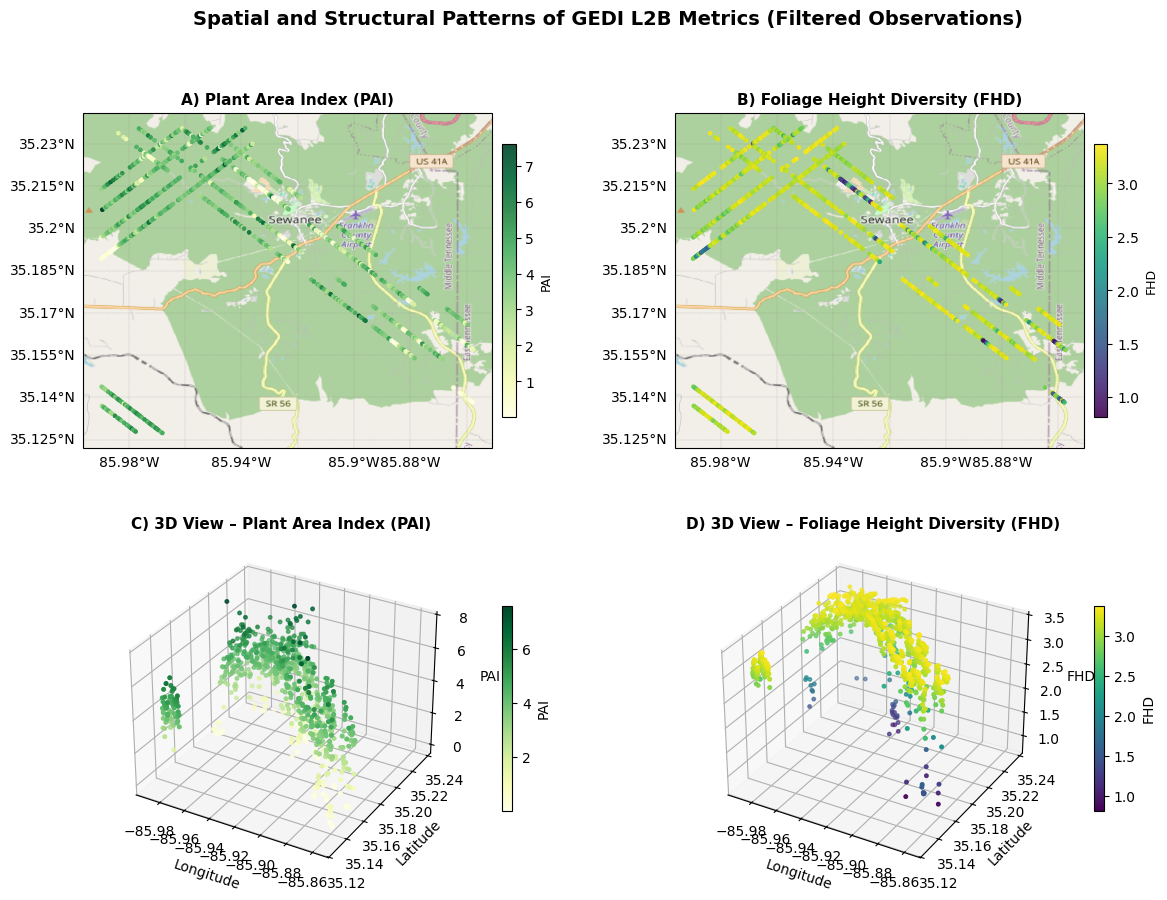

✅ Figure saved as 'GEDI_PAI_FHD_panels_OSM.tif' (600 DPI, publication-ready)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# === Load and Clean GEDI Data ===
csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
df = pd.read_csv(csv_path)

# Replace invalids and drop NaNs
df.replace([-9999, -9999.0], np.nan, inplace=True)
df = df.dropna(subset=['lat', 'lon', 'pai', 'fhd_normal', 'digital_elevation_model'])

# === Setup Figure ===
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.25)
proj = ccrs.PlateCarree()

# === Define Basemap (OpenStreetMap) ===
osm_tiles = cimgt.OSM()  # OpenStreetMap tiles

# --------------------------------------------------------------------
# PANEL A – PAI Map with OSM Basemap
# --------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax1.set_title('A) Plant Area Index (PAI)', fontsize=11, weight='bold')
ax1.add_image(osm_tiles, 12)  # Zoom level 12
sc1 = ax1.scatter(df['lon'], df['lat'], c=df['pai'], cmap='YlGn', s=10,
                  transform=proj, edgecolor='none', alpha=0.9)
# Remove top/right labels
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
cb1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.8, pad=0.02)
cb1.set_label('PAI', fontsize=9)

# --------------------------------------------------------------------
# PANEL B – FHD Map with OSM Basemap
# --------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1], projection=proj)
ax2.set_title('B) Foliage Height Diversity (FHD)', fontsize=11, weight='bold')
ax2.add_image(osm_tiles, 12)
sc2 = ax2.scatter(df['lon'], df['lat'], c=df['fhd_normal'], cmap='viridis', s=10,
                  transform=proj, edgecolor='none', alpha=0.9)
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
cb2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', shrink=0.8, pad=0.02)
cb2.set_label('FHD', fontsize=9)

# --------------------------------------------------------------------
# PANEL C – PAI 3D Scatter
# --------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0], projection='3d')
sc3 = ax3.scatter(df['lon'], df['lat'], df['pai'], c=df['pai'], cmap='YlGn', s=6)
ax3.set_title('C) 3D View – Plant Area Index (PAI)', fontsize=11, weight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_zlabel('PAI')
cbar3 = plt.colorbar(sc3, ax=ax3, shrink=0.6, pad=0.1)
cbar3.set_label('PAI')

# --------------------------------------------------------------------
# PANEL D – FHD 3D Scatter
# --------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1], projection='3d')
sc4 = ax4.scatter(df['lon'], df['lat'], df['fhd_normal'], c=df['fhd_normal'], cmap='viridis', s=6)
ax4.set_title('D) 3D View – Foliage Height Diversity (FHD)', fontsize=11, weight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_zlabel('FHD')
cbar4 = plt.colorbar(sc4, ax=ax4, shrink=0.6, pad=0.1)
cbar4.set_label('FHD')

# === Final Formatting ===
plt.suptitle('Spatial and Structural Patterns of GEDI L2B Metrics (Filtered Observations)', fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# === Save High-Resolution Output ===
plt.savefig('/content/GEDI_PAI_FHD_panels_OSM.png', dpi=600, bbox_inches='tight')
plt.show()

print("✅ Figure saved as 'GEDI_PAI_FHD_panels_OSM.tif' (600 DPI, publication-ready)")


In [21]:
import h5py
import os
import numpy as np

data_dir = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target'
beam_groups = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

# Count raw observations
raw_counts = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.h5'):
            with h5py.File(os.path.join(root, file), 'r') as f:
                for beam in beam_groups:
                    if beam in f:
                        # Use lat_lowestmode as a proxy for number of shots
                        raw_counts += len(f[beam]['geolocation/lat_lowestmode'][:])

print(f"Total raw GEDI observations across all beams: {raw_counts}")


Total raw GEDI observations across all beams: 15914


In [22]:
import pandas as pd

csv_path = '/content/drive/MyDrive/PhD_Main_Folder/Geo_Data/Sewanee_DL_Project/GEDI_target/filtered_csvs/GEDI_filtered_merged.csv'
df_filtered = pd.read_csv(csv_path)

print(f"Total filtered GEDI observations: {len(df_filtered)}")


Total filtered GEDI observations: 1771
